# Regression Model for Dublin Bikes Project
<br/>
On examination and exploration of the data it proved difficult to find any strong linear relationships. This led us to the conclusion that a Random Forest model may be the best option. We had just begun to learn about Random Forest in our Data Analytics module so we did not have much experience with it. This provided a perfect opportunity t try it out. <br/> <br/>
The model seems to have quite a high level of accuracy. It has an R2 of 0.7028792458663189 and a MAE of 4.28. <br/><br/>
Initially, we had planned to use the weather data and incorporate this into the model. However, due to time constraints and issues surrounding getting forecast data, we decided to use solely the bike station data for the model. As can be seen the weather and bike data frames were merged in this notebook in anticipation of doing this. <br><br/>
The user chooses the station, day of the week, and time and gets a prediciton of the number of available bikes.

In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import seaborn as sns
# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

C:\Users\Thomas Grogan\Anaconda3\envs\comp47350\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Read in the filtered data from the csv file. 
# Print first 10 rows of dataframe.

df = pd.read_csv(
         'dynamicDataFiltered.csv',
         dtype={"number": int, "available_bikes": int, "available_bike_stands": int},
         parse_dates=['last_update'],
         dayfirst=True,
         #header=0, 
         #skiprows=lambda i: i>0 and random.random() > p
)

df.head(10)

,number,status,available_bikes,available_bike_stands,last_update
0,42,OPEN,4,26,2020-02-12 15:46:00
1,30,OPEN,1,19,2020-02-12 15:46:00
2,54,OPEN,12,21,2020-02-12 15:49:00
3,108,OPEN,19,21,2020-02-12 15:54:00
4,56,OPEN,36,4,2020-02-12 15:54:00
5,6,OPEN,6,14,2020-02-12 15:51:00
6,18,OPEN,0,30,2020-02-12 15:49:00
7,32,OPEN,20,10,2020-02-12 15:54:00
8,52,OPEN,4,28,2020-02-12 15:54:00
9,48,OPEN,25,15,2020-02-12 15:45:00


In [3]:
# Assign static data from csv to df1.

df1 = pd.read_csv('staticData.csv')
df1.head(10)

,number,name,address,latitude,longitude,banking,total_stands
0,2,BLESSINGTON STREET,Blessington Street,53.356769,-6.268140,True,20
1,3,BOLTON STREET,Bolton Street,53.351182,-6.269859,False,20
2,4,GREEK STREET,Greek Street,53.346874,-6.272976,False,20
3,5,CHARLEMONT PLACE,Charlemont Street,53.330662,-6.260177,False,40
4,6,CHRISTCHURCH PLACE,Christchurch Place,53.343368,-6.270120,False,20
5,7,HIGH STREET,High Street,53.343565,-6.275071,True,29
6,8,CUSTOM HOUSE QUAY,Custom House Quay,53.347884,-6.248048,False,30
7,9,EXCHEQUER STREET,Exchequer Street,53.343034,-6.263578,False,24
8,10,DAME STREET,Dame Street,53.344007,-6.266802,True,16
9,11,EARLSFORT TERRACE,Earlsfort Terrace,53.334019,-6.258371,False,30


In [4]:
df.head(100)

,number,status,available_bikes,available_bike_stands,last_update
0,42,OPEN,4,26,2020-02-12 15:46:00
1,30,OPEN,1,19,2020-02-12 15:46:00
2,54,OPEN,12,21,2020-02-12 15:49:00
3,108,OPEN,19,21,2020-02-12 15:54:00
4,56,OPEN,36,4,2020-02-12 15:54:00
...,...,...,...,...,...
95,89,OPEN,22,18,2020-02-12 15:46:00
96,57,OPEN,20,3,2020-02-12 15:47:00
97,80,OPEN,13,27,2020-02-12 15:45:00
98,41,OPEN,15,5,2020-02-12 15:45:00


In [5]:
df.shape


(795044, 5)

In [6]:
df1.shape

(109, 7)

In [7]:
# Assign weather data from weatherData.csv to weather_df.
weather_df = pd.read_csv('weatherData.csv')

In [8]:
# Check for rows with null values.
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [9]:
print(rows_with_NaN)

Empty DataFrame
Columns: [number, status, available_bikes, available_bike_stands, last_update]
Index: []


In [10]:
is_NaN = df1.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df1[row_has_NaN]

In [11]:
print(rows_with_NaN)

Empty DataFrame
Columns: [number, name, address, latitude, longitude, banking, total_stands]
Index: []


In [12]:
# Examine data types of bike data frames.
df.dtypes

number                            int32
status                           object
available_bikes                   int32
available_bike_stands             int32
last_update              datetime64[ns]
dtype: object

In [13]:
df1.dtypes

number            int64
name             object
address          object
latitude        float64
longitude       float64
banking            bool
total_stands      int64
dtype: object

In [14]:
df.tail()

,number,status,available_bikes,available_bike_stands,last_update
795039,108,OPEN,23,17,2020-03-13 21:14:00
795040,108,OPEN,23,17,2020-03-13 21:14:00
795041,108,OPEN,23,17,2020-03-13 21:14:00
795042,108,OPEN,23,17,2020-03-13 21:14:00
795043,108,OPEN,23,17,2020-03-13 21:14:00


In [15]:
df.tail()

,number,status,available_bikes,available_bike_stands,last_update
795039,108,OPEN,23,17,2020-03-13 21:14:00
795040,108,OPEN,23,17,2020-03-13 21:14:00
795041,108,OPEN,23,17,2020-03-13 21:14:00
795042,108,OPEN,23,17,2020-03-13 21:14:00
795043,108,OPEN,23,17,2020-03-13 21:14:00


In [16]:
df['available_bikes'] = pd.to_numeric(df['available_bikes'], errors='coerce')

In [17]:
print (df[ pd.to_numeric(df['available_bikes'], errors='coerce').isnull()])

Empty DataFrame
Columns: [number, status, available_bikes, available_bike_stands, last_update]
Index: []


In [18]:
df['available_bikes'] = df['available_bikes'].astype('int32')

In [19]:
df.dtypes

number                            int32
status                           object
available_bikes                   int32
available_bike_stands             int32
last_update              datetime64[ns]
dtype: object

In [20]:
print (df[ pd.to_numeric(df['available_bikes'], errors='coerce').isnull()])

Empty DataFrame
Columns: [number, status, available_bikes, available_bike_stands, last_update]
Index: []


In [21]:
print (df[ pd.to_numeric(df['available_bike_stands'], errors='coerce').isnull()])

Empty DataFrame
Columns: [number, status, available_bikes, available_bike_stands, last_update]
Index: []


In [22]:
# Decriptive stats for dynamic data.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number,795044.0,60.175146,33.695815,2.0,31.0,61.0,90.0,117.0
available_bikes,795044.0,11.573775,10.844176,0.0,2.0,9.0,19.0,40.0
available_bike_stands,795044.0,20.487466,11.762339,0.0,11.0,20.0,30.0,41.0


In [23]:
# Descriptive stats for static data.
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
number,109.0,60.009174,33.654149,2.000000,31.000000,61.000000,89.000000,117.000000
latitude,109.0,53.345407,0.007570,53.330091,53.339764,53.344304,53.350291,53.359967
longitude,109.0,-6.264671,0.018498,-6.310015,-6.276142,-6.263232,-6.251557,-6.230852
total_stands,109.0,32.201835,7.718160,16.000000,29.000000,30.000000,40.000000,40.000000


In [24]:
# Merge the two dataframes on number.

new_df = pd.merge(df,
                 df1[['number', 'latitude', 'longitude', 'banking', 'total_stands']],
                 on='number')
new_df.head(10)


,number,status,available_bikes,available_bike_stands,last_update,latitude,longitude,banking,total_stands
0,42,OPEN,4,26,2020-02-12 15:46:00,53.349562,-6.278198,True,30
1,42,OPEN,4,26,2020-02-12 15:56:00,53.349562,-6.278198,True,30
2,42,OPEN,4,26,2020-02-12 15:56:00,53.349562,-6.278198,True,30
3,42,OPEN,5,25,2020-02-12 16:04:00,53.349562,-6.278198,True,30
4,42,OPEN,5,25,2020-02-12 16:04:00,53.349562,-6.278198,True,30
5,42,OPEN,2,28,2020-02-13 09:36:00,53.349562,-6.278198,True,30
6,42,OPEN,2,28,2020-02-13 09:36:00,53.349562,-6.278198,True,30
7,42,OPEN,2,28,2020-02-13 09:44:00,53.349562,-6.278198,True,30
8,42,OPEN,1,29,2020-02-13 09:52:00,53.349562,-6.278198,True,30
9,42,OPEN,1,29,2020-02-13 10:02:00,53.349562,-6.278198,True,30


In [25]:
new_df.tail(10)

,number,status,available_bikes,available_bike_stands,last_update,latitude,longitude,banking,total_stands
790664,88,OPEN,0,30,2020-02-27 11:16:00,53.3488,-6.281637,False,30
790665,88,OPEN,0,30,2020-02-27 11:16:00,53.3488,-6.281637,False,30
790666,88,OPEN,0,30,2020-02-27 11:27:00,53.3488,-6.281637,False,30
790667,88,OPEN,0,30,2020-02-27 11:27:00,53.3488,-6.281637,False,30
790668,88,OPEN,0,30,2020-02-27 11:37:00,53.3488,-6.281637,False,30
790669,88,OPEN,1,29,2020-02-27 11:40:00,53.3488,-6.281637,False,30
790670,88,OPEN,1,29,2020-02-27 11:40:00,53.3488,-6.281637,False,30
790671,88,OPEN,2,28,2020-02-27 11:54:00,53.3488,-6.281637,False,30
790672,88,OPEN,2,28,2020-02-27 11:54:00,53.3488,-6.281637,False,30
790673,88,OPEN,2,28,2020-02-27 12:04:00,53.3488,-6.281637,False,30


In [26]:
new_df.shape

(790674, 9)

In [27]:
# Make status column type category.
new_df['status'] = new_df['status'].astype('category')

In [28]:
# Remove row that have last_update before 2020-02-19 at 13:00 as this is when we started collecting weather data.
mask = (new_df['last_update'] > "2020-02-19 13:00:00")

In [29]:
new_df = new_df.loc[mask]

In [30]:
new_df.shape

(722027, 9)

In [31]:
new_df.tail()

,number,status,available_bikes,available_bike_stands,last_update,latitude,longitude,banking,total_stands
790669,88,OPEN,1,29,2020-02-27 11:40:00,53.3488,-6.281637,False,30
790670,88,OPEN,1,29,2020-02-27 11:40:00,53.3488,-6.281637,False,30
790671,88,OPEN,2,28,2020-02-27 11:54:00,53.3488,-6.281637,False,30
790672,88,OPEN,2,28,2020-02-27 11:54:00,53.3488,-6.281637,False,30
790673,88,OPEN,2,28,2020-02-27 12:04:00,53.3488,-6.281637,False,30


In [32]:
new_df.head()

,number,status,available_bikes,available_bike_stands,last_update,latitude,longitude,banking,total_stands
632,42,OPEN,9,21,2020-02-19 13:04:00,53.349562,-6.278198,True,30
633,42,OPEN,9,21,2020-02-19 13:05:00,53.349562,-6.278198,True,30
634,42,OPEN,7,23,2020-02-19 13:14:00,53.349562,-6.278198,True,30
635,42,OPEN,5,25,2020-02-19 13:17:00,53.349562,-6.278198,True,30
636,42,OPEN,2,27,2020-02-19 13:24:00,53.349562,-6.278198,True,30


In [33]:
# Decriptive stats for merged data frame.
new_df.describe().T

,count,mean,std,min,25%,50%,75%,max
number,722027.0,59.852558,33.534574,2.000000,31.000000,61.000000,89.000000,117.000000
available_bikes,722027.0,11.661683,10.832494,0.000000,2.000000,9.000000,19.000000,40.000000
available_bike_stands,722027.0,20.408893,11.772794,0.000000,11.000000,20.000000,30.000000,41.000000
latitude,722027.0,53.345390,0.007556,53.330091,53.339764,53.344304,53.350291,53.359967
longitude,722027.0,-6.264571,0.018420,-6.310015,-6.276142,-6.263232,-6.251557,-6.230852
total_stands,722027.0,32.217400,7.703931,16.000000,29.000000,30.000000,40.000000,40.000000


In [34]:
# Select all the continuous data.
continuous_columns = new_df.select_dtypes(['int32', 'int64', 'float64']).columns

In [35]:
continuous_columns

Index(['number', 'available_bikes', 'available_bike_stands', 'latitude',
       'longitude', 'total_stands'],
      dtype='object')

In [36]:
new_df[continuous_columns].head()

,number,available_bikes,available_bike_stands,latitude,longitude,total_stands
632,42,9,21,53.349562,-6.278198,30
633,42,9,21,53.349562,-6.278198,30
634,42,7,23,53.349562,-6.278198,30
635,42,5,25,53.349562,-6.278198,30
636,42,2,27,53.349562,-6.278198,30


In [37]:
# Check numbers of unique values in each column.
new_df.nunique()

number                     109
status                       2
available_bikes             41
available_bike_stands       42
last_update              32615
latitude                   109
longitude                  109
banking                      2
total_stands                17
dtype: int64

In [38]:
# Check fo null values.
new_df.isnull().sum()

number                   0
status                   0
available_bikes          0
available_bike_stands    0
last_update              0
latitude                 0
longitude                0
banking                  0
total_stands             0
dtype: int64

In [39]:
# Create variable categorical_columns for columns of type category.
new_df['banking'] = new_df['banking'].astype('category')
categorical_columns = new_df.select_dtypes(['category']).columns

In [40]:
categorical_columns

Index(['status', 'banking'], dtype='object')

In [41]:
new_df[categorical_columns].describe().T

,count,unique,top,freq
status,722027,2,OPEN,720076
banking,722027,2,False,488847


In [42]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', new_df.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', new_df[new_df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  277487
Number of duplicate rows (including first) in the table is: 547016


In [43]:
new_df = new_df.drop_duplicates()

In [44]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', new_df.duplicated().sum())

Number of duplicate (excluding first) rows in the table is:  0


In [45]:
# Check for irregular cardinality in categorical features.
print("Unique values for:\n- number:", pd.unique(new_df.number.ravel()))
print("\n- status:", pd.unique(new_df.status.ravel()))
print("\n- available_bikes:", pd.unique(new_df.available_bikes.ravel()))
print("\n- available_bike_stands:", pd.unique(new_df.available_bike_stands.ravel()))
print("\n- latitude:", pd.unique(new_df.latitude.ravel()))
print("\n- longitude:", pd.unique(new_df.longitude.ravel()))
print("\n- banking:", pd.unique(new_df.banking.ravel()))
print("\n- total_stands:", pd.unique(new_df.total_stands.ravel()))

Unique values for:
- number: [ 42  30  54 108  56   6  18  32  52  48  13  43  81  31  98  23 106 112
  68  74  87  84  90  11  17  45 114  72  63 113  91  99   9  67  55  62
   5  97  61  77  73   4  49  19   7 102  38  53  58  66 104 101 115  47
 117   8  27  16  96  82  76  71  79  69  25  51  37  59  95  94 105  36
  93  22  50 110  12  34  78   2  75 111  26  65  15  86  10 100  24  64
 109  85 107  33  44  89  57  80  41   3  40  29 103  28  39  83  92  21
  88]

- status: ['OPEN' 'CLOSED']

- available_bikes: [ 9  7  5  2  3  4  6  8 10 12 13 15 18 17 21 23 24 27 26 28 30 29 25 20
 19 16 14 11  1  0 22 31 33 34 35 36 32 38 37 39 40]

- available_bike_stands: [21 23 25 27 26 24 22 20 18 17 15 12 13  9  7  6  3  4  2  0  1  5 10 11
 16 19 28 30 29  8 14 31 33 32 34 35 36 37 38 39 40 41]

- latitude: [53.349562 53.353462 53.336021 53.359405 53.33796  53.343368 53.334123
 53.344304 53.338755 53.347777 53.336074 53.330091 53.339983 53.350929
 53.341515 53.348279 53.35893  53.357841 5

C:\Users\Thomas Grogan\Anaconda3\envs\comp47350\lib\site-packages\pandas\core\series.py:631: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  return self._values.ravel(order=order)


In [46]:
# Add day column.
new_df['day'] = new_df['last_update'].dt.weekday

In [47]:
# Add hour columm.
new_df['hour'] = new_df['last_update'].dt.hour

In [48]:
new_df.shape

(444540, 11)

In [49]:
# Remove rows where the hour is less that 5 because the stations are closed from midnight until 5am.
mask = (new_df['hour'] > 4)

In [50]:
new_df = new_df.loc[mask]

In [51]:
new_df.shape

(367800, 11)

In [52]:
new_df.head()

,number,status,available_bikes,available_bike_stands,last_update,latitude,longitude,banking,total_stands,day,hour
632,42,OPEN,9,21,2020-02-19 13:04:00,53.349562,-6.278198,True,30,2,13
633,42,OPEN,9,21,2020-02-19 13:05:00,53.349562,-6.278198,True,30,2,13
634,42,OPEN,7,23,2020-02-19 13:14:00,53.349562,-6.278198,True,30,2,13
635,42,OPEN,5,25,2020-02-19 13:17:00,53.349562,-6.278198,True,30,2,13
636,42,OPEN,2,27,2020-02-19 13:24:00,53.349562,-6.278198,True,30,2,13


In [53]:
new_df.tail()

,number,status,available_bikes,available_bike_stands,last_update,latitude,longitude,banking,total_stands,day,hour
790666,88,OPEN,0,30,2020-02-27 11:27:00,53.3488,-6.281637,False,30,3,11
790668,88,OPEN,0,30,2020-02-27 11:37:00,53.3488,-6.281637,False,30,3,11
790669,88,OPEN,1,29,2020-02-27 11:40:00,53.3488,-6.281637,False,30,3,11
790671,88,OPEN,2,28,2020-02-27 11:54:00,53.3488,-6.281637,False,30,3,11
790673,88,OPEN,2,28,2020-02-27 12:04:00,53.3488,-6.281637,False,30,3,12


In [54]:
# Check that all data types are correct.
new_df.dtypes

number                            int32
status                         category
available_bikes                   int32
available_bike_stands             int32
last_update              datetime64[ns]
latitude                        float64
longitude                       float64
banking                        category
total_stands                      int64
day                               int64
hour                              int64
dtype: object

In [55]:
#new_df['day'] = new_df['day'].astype('category')

In [56]:
# Print the average available_bikes in our dataset.
# We could use this as a very simple baseline prediction model.
# A better prediction model should at least improve on this baseline model.
new_df.available_bikes.mean()

11.943988580750409

In [57]:
# Drop these columns as they will not be used. 
new_df = new_df.drop(['latitude'], axis=1)

In [58]:
new_df = new_df.drop(['longitude'], axis=1)

In [59]:
# Now look at the weather data frame.
weather_df.head()

,date,time,status,icon,rainProb,rainIntensity,temp,windSpeed
0,2020-02-19,11:37:05,Possible Drizzle,rain,0.25,0.0035,6,23.87
1,2020-02-19,11:39:40,Possible Drizzle,rain,0.25,0.0036,6,23.86
2,2020-02-19,13:00:04,Mostly Cloudy,partly-cloudy-day,0.23,0.0026,6,22.86
3,2020-02-19,14:00:02,Mostly Cloudy,partly-cloudy-day,0.17,0.0011,6,21.32
4,2020-02-19,15:00:02,Mostly Cloudy,partly-cloudy-day,0.15,0.0007,6,19.80


In [60]:
weather_df.shape

(997, 8)

In [61]:
weather_df.tail()

,date,time,status,icon,rainProb,rainIntensity,temp,windSpeed
992,2020-04-03,11:00:07,Partly Cloudy,partly-cloudy-day,0.03,0.0004,8,13.13
993,2020-04-03,12:00:03,Mostly Cloudy,partly-cloudy-day,0.03,0.0005,8,13.17
994,2020-04-03,13:00:03,Mostly Cloudy,partly-cloudy-day,0.04,0.0004,8,13.94
995,2020-04-03,14:00:02,Mostly Cloudy,partly-cloudy-day,0.03,0.0003,8,14.49
996,2020-04-03,15:00:03,Mostly Cloudy,partly-cloudy-day,0.03,0.0003,7,14.64


In [62]:
# Choose columns which should be categorical. 
weather_categorical_cols = weather_df[['status', 'icon']].columns

for col in weather_categorical_cols:
    weather_df[col] = weather_df[col].astype('category')

In [63]:
# Create one date_time column by combining two exisiting columns.
weather_df['date_time'] = weather_df.date.str.cat(weather_df.time, sep=" ")

In [64]:
weather_df.head()

,date,time,status,icon,rainProb,rainIntensity,temp,windSpeed,date_time
0,2020-02-19,11:37:05,Possible Drizzle,rain,0.25,0.0035,6,23.87,2020-02-19 11:37:05
1,2020-02-19,11:39:40,Possible Drizzle,rain,0.25,0.0036,6,23.86,2020-02-19 11:39:40
2,2020-02-19,13:00:04,Mostly Cloudy,partly-cloudy-day,0.23,0.0026,6,22.86,2020-02-19 13:00:04
3,2020-02-19,14:00:02,Mostly Cloudy,partly-cloudy-day,0.17,0.0011,6,21.32,2020-02-19 14:00:02
4,2020-02-19,15:00:02,Mostly Cloudy,partly-cloudy-day,0.15,0.0007,6,19.80,2020-02-19 15:00:02


In [65]:
weather_df['date_time'] = weather_df['date_time'].astype('datetime64[ns]')

In [66]:
weather_df = weather_df.drop(['date'], axis=1)

In [67]:
weather_df = weather_df.drop(['time'], axis=1)

In [68]:
weather_df.head()

,status,icon,rainProb,rainIntensity,temp,windSpeed,date_time
0,Possible Drizzle,rain,0.25,0.0035,6,23.87,2020-02-19 11:37:05
1,Possible Drizzle,rain,0.25,0.0036,6,23.86,2020-02-19 11:39:40
2,Mostly Cloudy,partly-cloudy-day,0.23,0.0026,6,22.86,2020-02-19 13:00:04
3,Mostly Cloudy,partly-cloudy-day,0.17,0.0011,6,21.32,2020-02-19 14:00:02
4,Mostly Cloudy,partly-cloudy-day,0.15,0.0007,6,19.80,2020-02-19 15:00:02


In [69]:
weather_df.dtypes

status                 category
icon                   category
rainProb                float64
rainIntensity           float64
temp                      int64
windSpeed               float64
date_time        datetime64[ns]
dtype: object

In [70]:
# Only keep columns that we think we'll need.
new_weather_df = weather_df[['rainProb', 'rainIntensity', 'temp', 'windSpeed', 'date_time']]
new_weather_df.head()

,rainProb,rainIntensity,temp,windSpeed,date_time
0,0.25,0.0035,6,23.87,2020-02-19 11:37:05
1,0.25,0.0036,6,23.86,2020-02-19 11:39:40
2,0.23,0.0026,6,22.86,2020-02-19 13:00:04
3,0.17,0.0011,6,21.32,2020-02-19 14:00:02
4,0.15,0.0007,6,19.80,2020-02-19 15:00:02


In [71]:
# Sort dataframes based on date and time.
new_df.sort_values('last_update', inplace=True)
new_weather_df.sort_values('date_time', inplace=True)

C:\Users\Thomas Grogan\Anaconda3\envs\comp47350\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
new_df.tail()

,number,status,available_bikes,available_bike_stands,last_update,banking,total_stands,day,hour
620090,15,OPEN,11,3,2020-03-13 23:59:00,False,16,4,23
445102,76,OPEN,20,18,2020-03-13 23:59:00,False,38,4,23
182542,17,OPEN,5,15,2020-03-13 23:59:00,False,20,4,23
153362,87,OPEN,24,14,2020-03-13 23:59:00,True,38,4,23
204426,72,OPEN,28,3,2020-03-13 23:59:00,False,31,4,23


In [73]:
new_weather_df.tail()

,rainProb,rainIntensity,temp,windSpeed,date_time
992,0.03,0.0004,8,13.13,2020-04-03 11:00:07
993,0.03,0.0005,8,13.17,2020-04-03 12:00:03
994,0.04,0.0004,8,13.94,2020-04-03 13:00:03
995,0.03,0.0003,8,14.49,2020-04-03 14:00:02
996,0.03,0.0003,7,14.64,2020-04-03 15:00:03


In [74]:
# Remove rows from weather data from 14th March onwards. This data would have been dramatically effected by the Coronavirus retrictions.
mask = (new_weather_df['date_time'] < "2020-03-14 00:00:00")

new_weather_df = new_weather_df.loc[mask]

new_weather_df.tail()

,rainProb,rainIntensity,temp,windSpeed,date_time
496,0.02,0.0002,5,8.22,2020-03-13 19:00:03
497,0.00,0.0000,4,6.68,2020-03-13 20:00:01
498,0.00,0.0000,4,5.68,2020-03-13 21:00:02
499,0.00,0.0000,4,4.48,2020-03-13 22:00:01
500,0.00,0.0000,3,3.37,2020-03-13 23:00:05


In [75]:
# Merge the two dataframes based on the date and time.
final_df = pd.merge_asof(new_df, new_weather_df, left_on='last_update', right_on='date_time')

In [76]:
final_df.shape

final_df.tail()

,number,status,available_bikes,available_bike_stands,last_update,banking,total_stands,day,hour,rainProb,rainIntensity,temp,windSpeed,date_time
367795,15,OPEN,11,3,2020-03-13 23:59:00,False,16,4,23,0.0,0.0,3,3.37,2020-03-13 23:00:05
367796,76,OPEN,20,18,2020-03-13 23:59:00,False,38,4,23,0.0,0.0,3,3.37,2020-03-13 23:00:05
367797,17,OPEN,5,15,2020-03-13 23:59:00,False,20,4,23,0.0,0.0,3,3.37,2020-03-13 23:00:05
367798,87,OPEN,24,14,2020-03-13 23:59:00,True,38,4,23,0.0,0.0,3,3.37,2020-03-13 23:00:05
367799,72,OPEN,28,3,2020-03-13 23:59:00,False,31,4,23,0.0,0.0,3,3.37,2020-03-13 23:00:05


In [77]:
final_df.head()

,number,status,available_bikes,available_bike_stands,last_update,banking,total_stands,day,hour,rainProb,rainIntensity,temp,windSpeed,date_time
0,76,OPEN,4,34,2020-02-19 13:01:00,False,38,2,13,0.23,0.0026,6,22.86,2020-02-19 13:00:04
1,115,OPEN,2,27,2020-02-19 13:01:00,False,30,2,13,0.23,0.0026,6,22.86,2020-02-19 13:00:04
2,91,OPEN,2,28,2020-02-19 13:01:00,False,30,2,13,0.23,0.0026,6,22.86,2020-02-19 13:00:04
3,51,OPEN,14,26,2020-02-19 13:01:00,False,40,2,13,0.23,0.0026,6,22.86,2020-02-19 13:00:04
4,55,OPEN,11,24,2020-02-19 13:01:00,False,36,2,13,0.23,0.0026,6,22.86,2020-02-19 13:00:04


In [78]:
new_df.shape

(367800, 9)

In [79]:
final_df.shape

(367800, 14)

In [80]:
final_df = final_df.drop(['date_time'], axis=1)

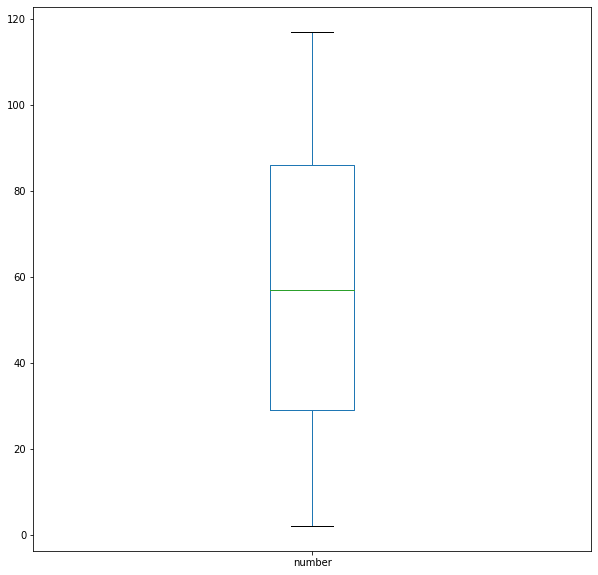

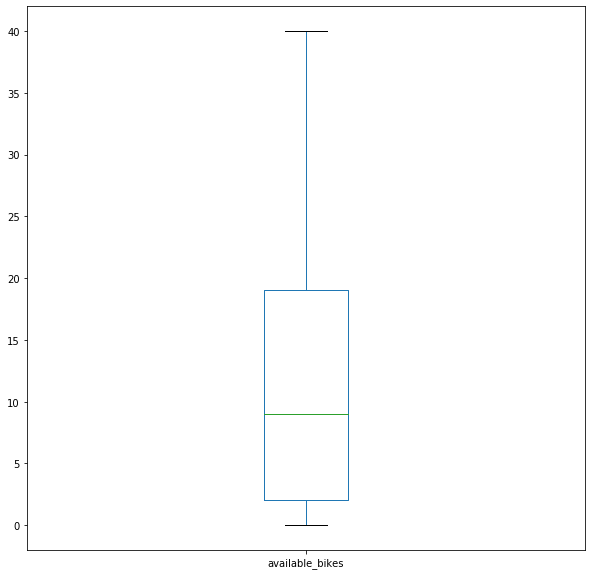

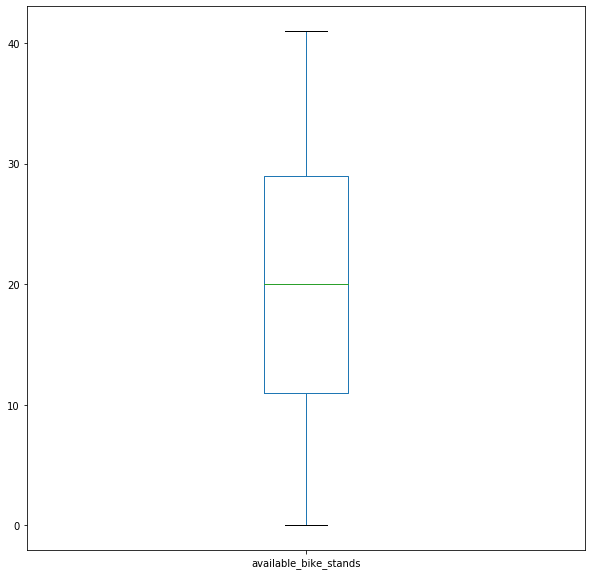

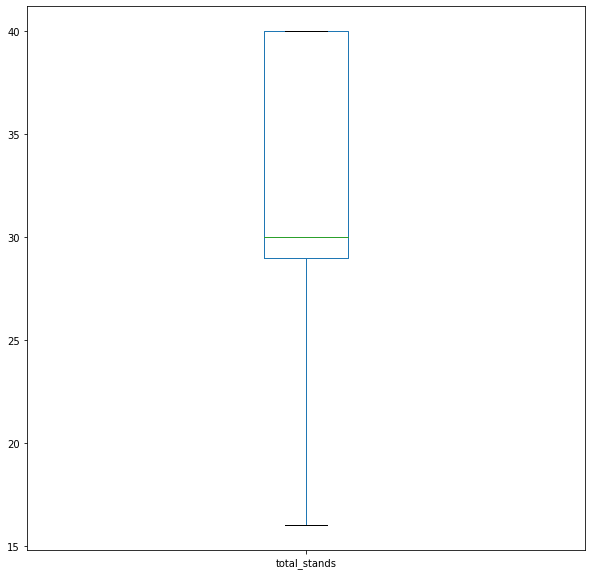

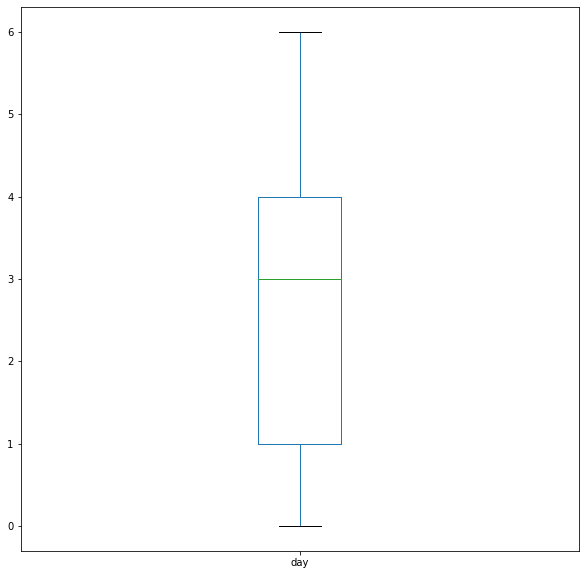

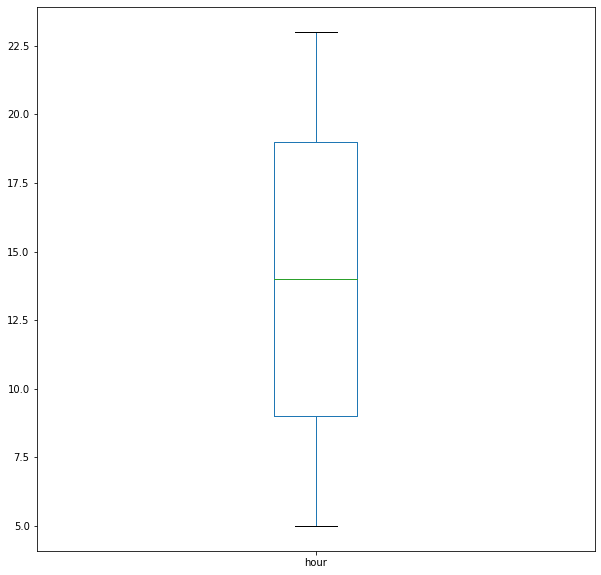

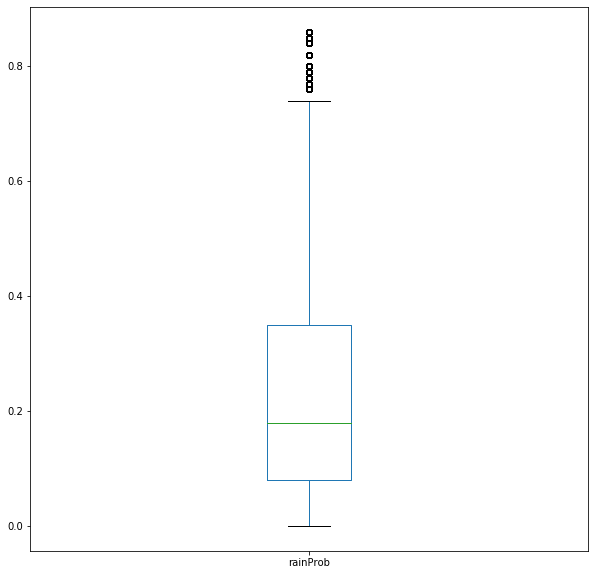

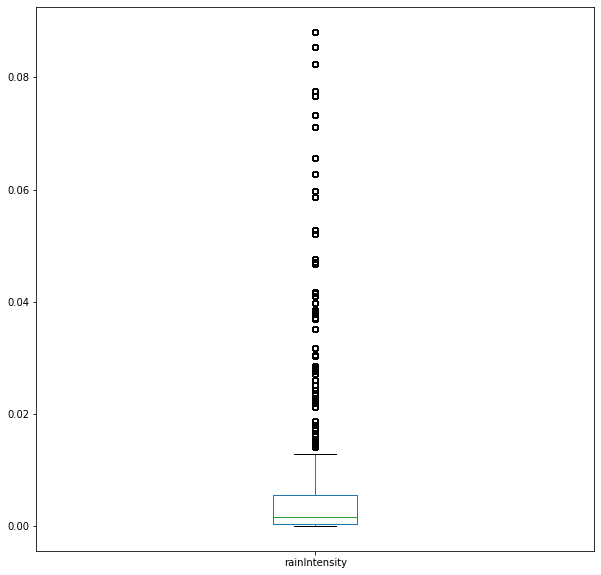

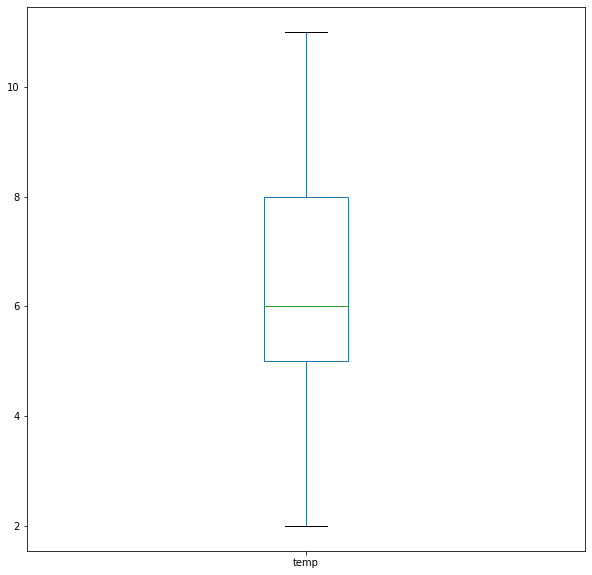

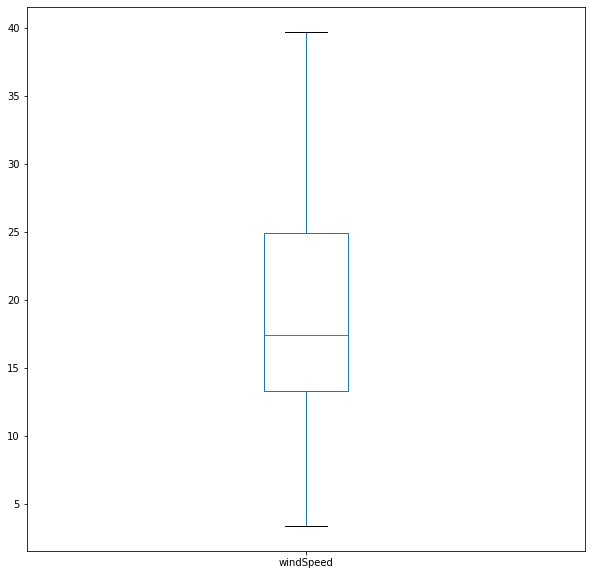

In [81]:
# Plot boxplots for the continuous columns.
continuous_columns = final_df.select_dtypes(['int32', 'int64', 'float64']).columns
for col in continuous_columns:
    f = final_df[col].plot(kind='box', figsize=(10, 10))
    plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0B2876688>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

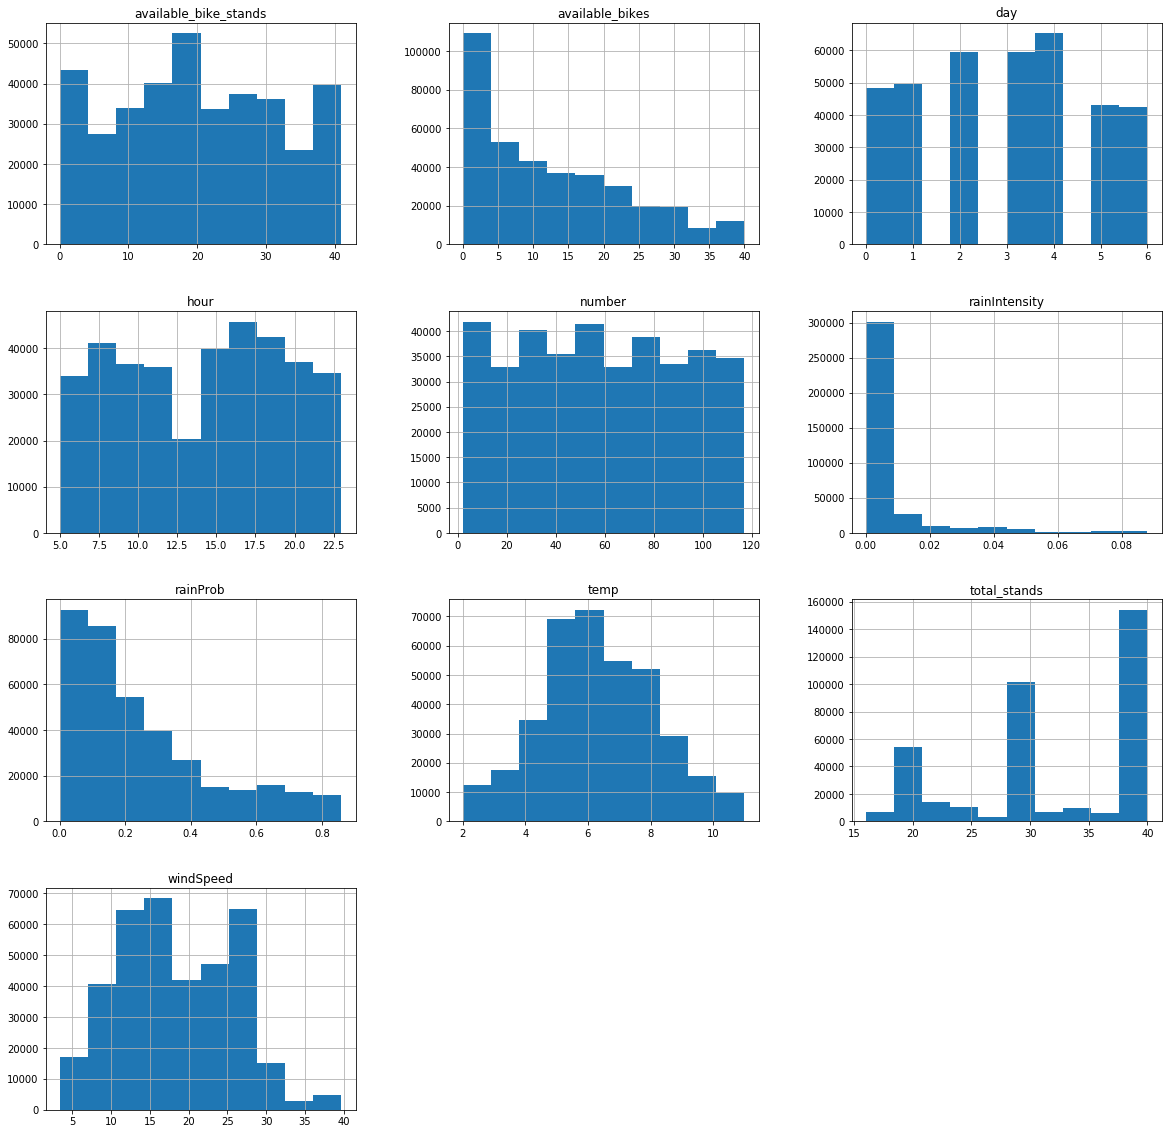

In [82]:
# Plot histograms for the continuous columns.
plt.figure()
final_df[continuous_columns].hist(figsize=(20, 20))

C:\Users\Thomas Grogan\Anaconda3\envs\comp47350\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


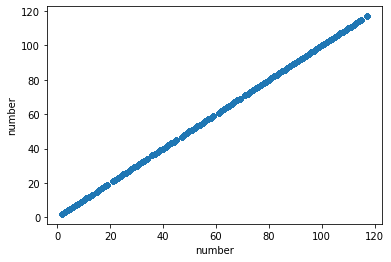

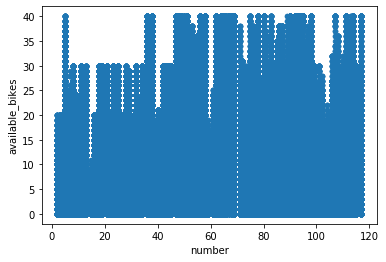

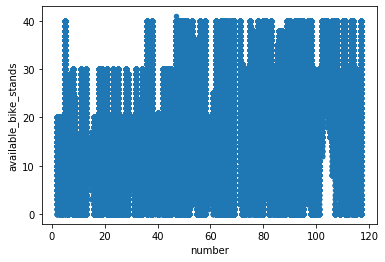

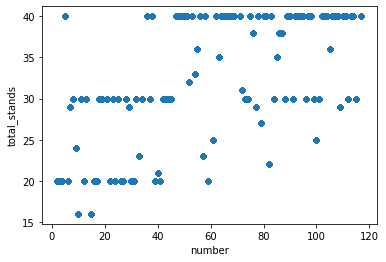

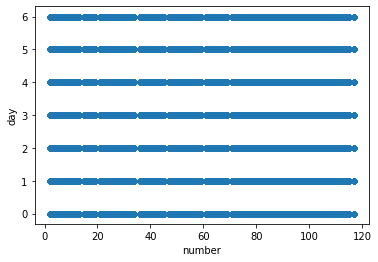

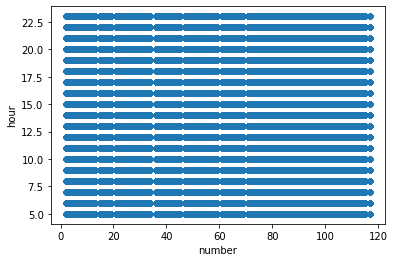

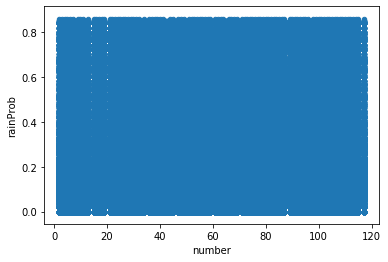

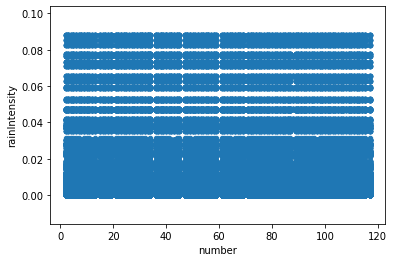

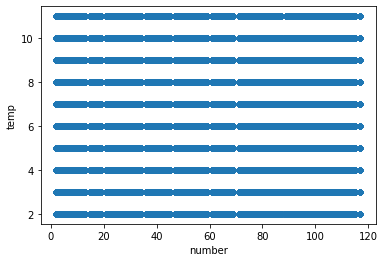

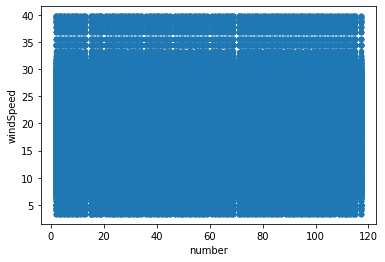

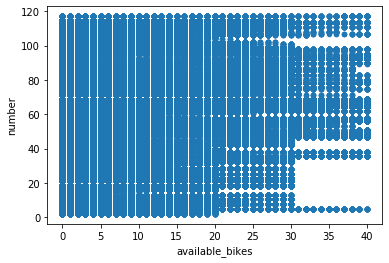

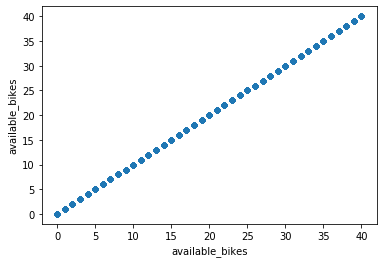

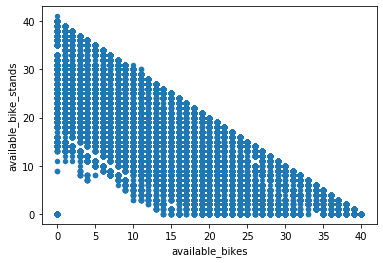

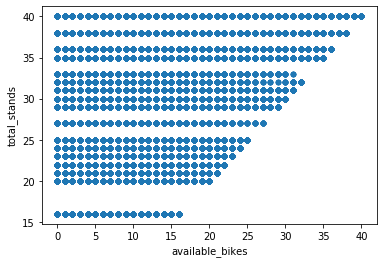

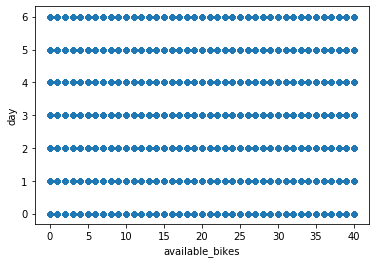

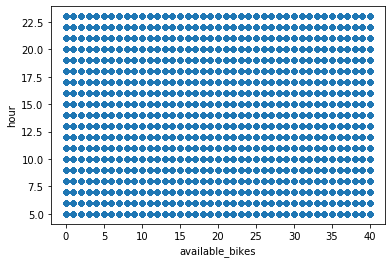

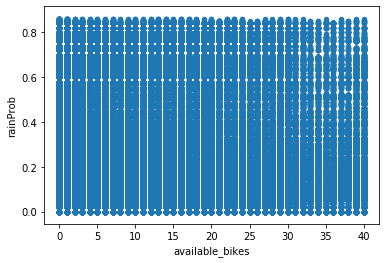

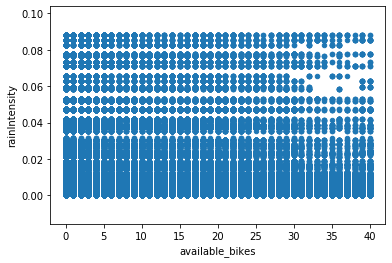

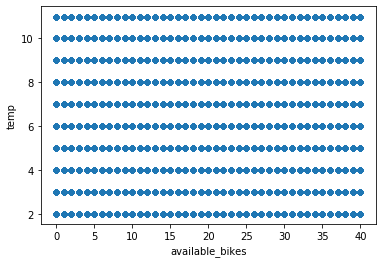

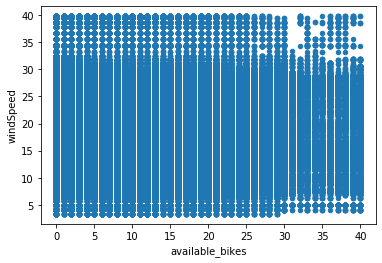

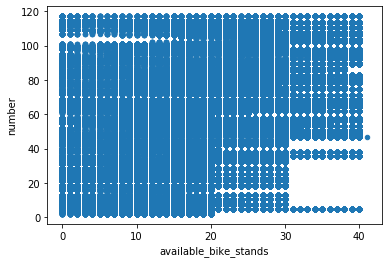

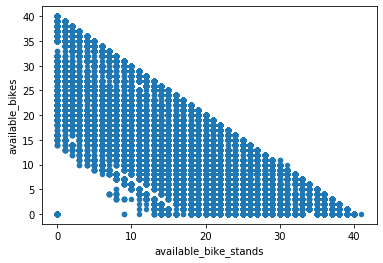

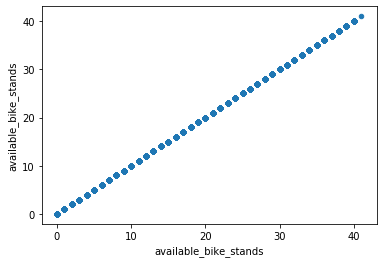

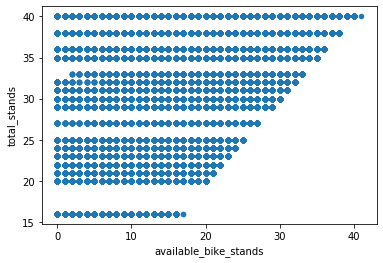

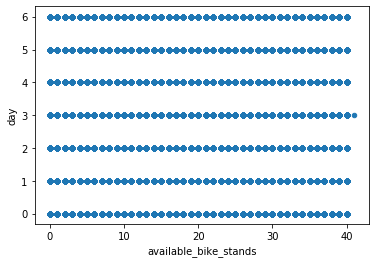

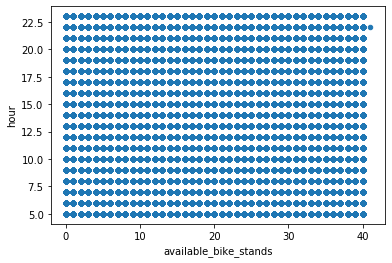

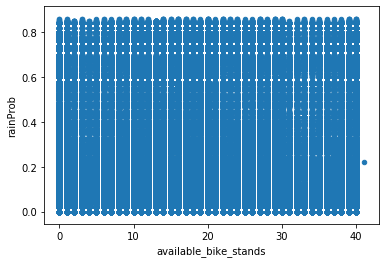

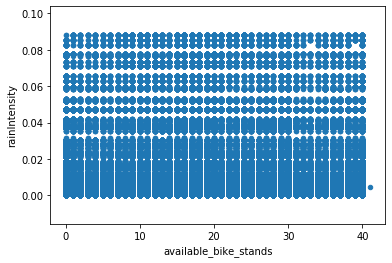

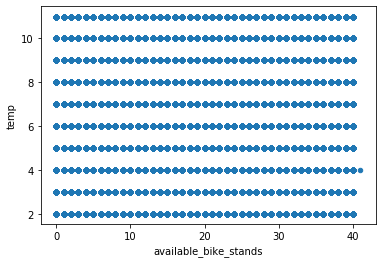

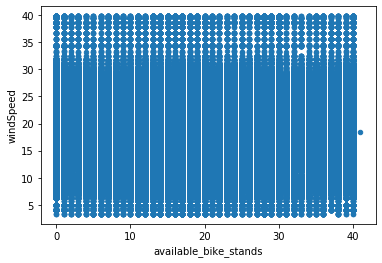

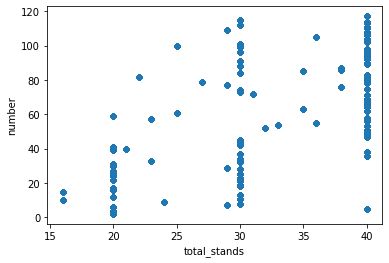

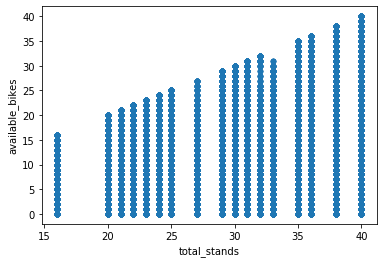

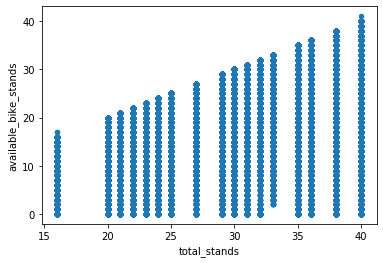

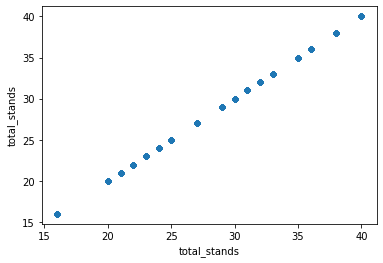

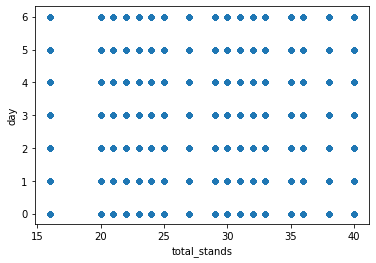

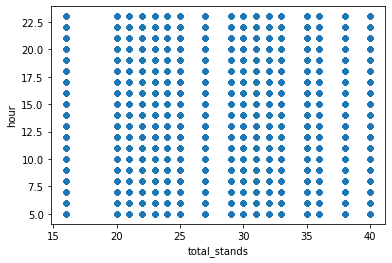

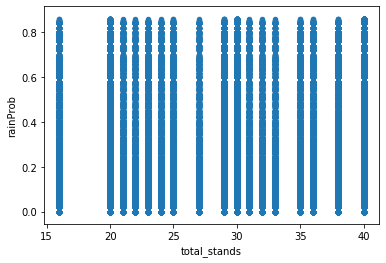

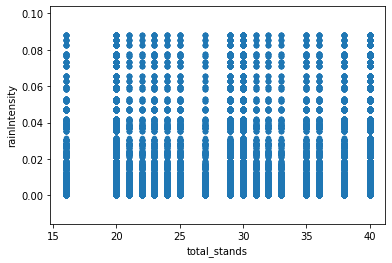

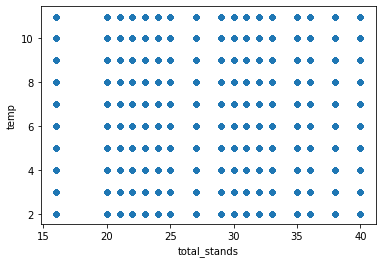

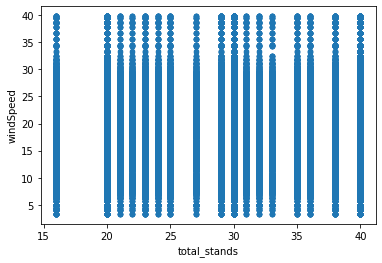

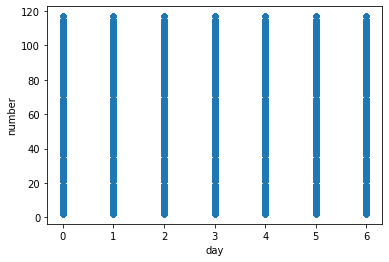

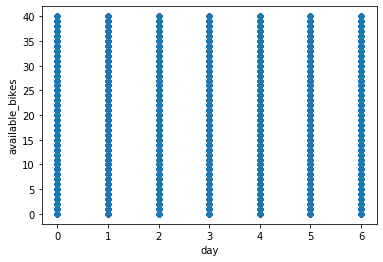

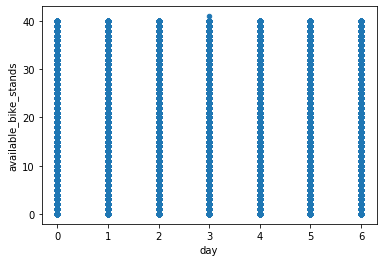

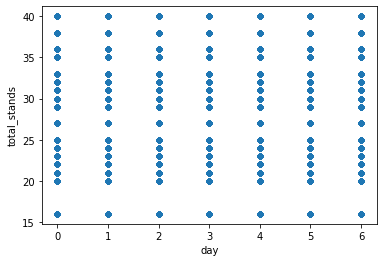

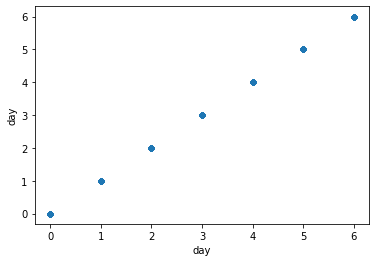

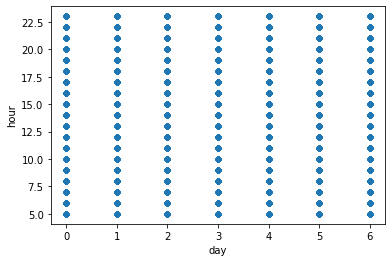

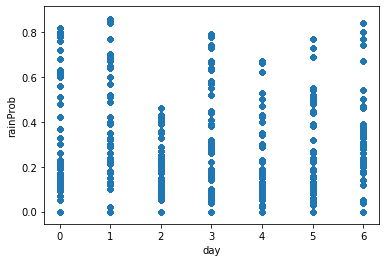

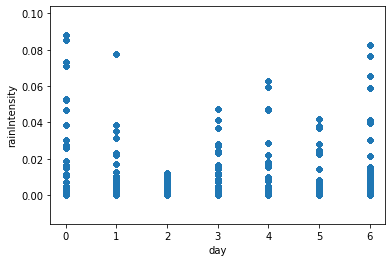

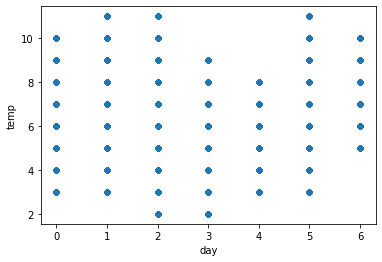

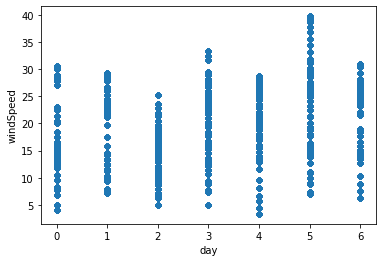

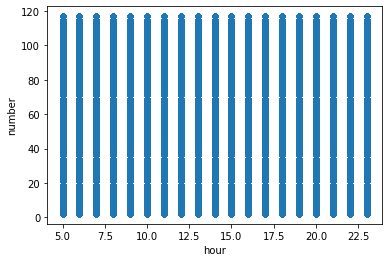

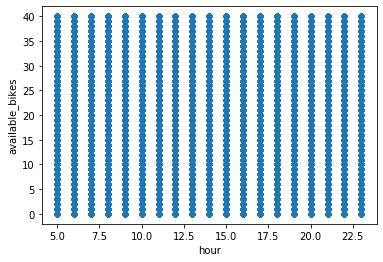

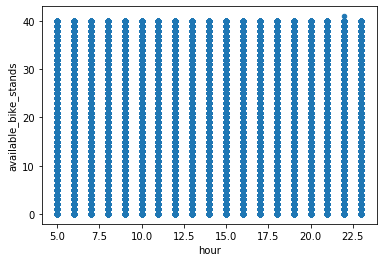

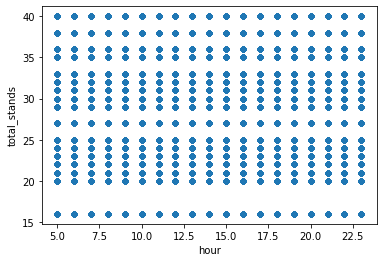

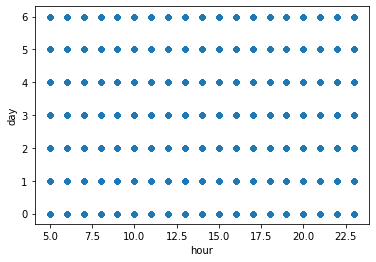

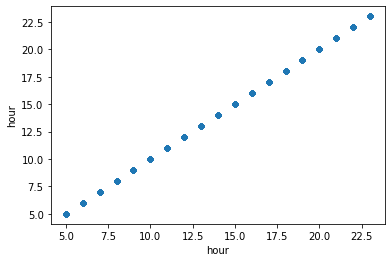

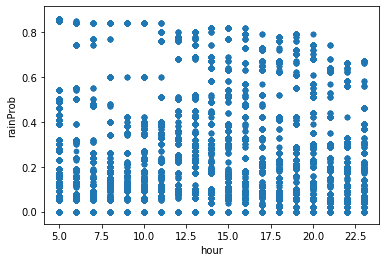

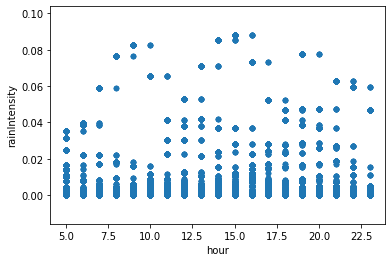

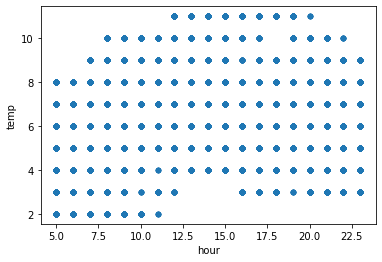

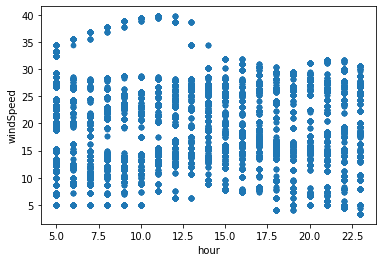

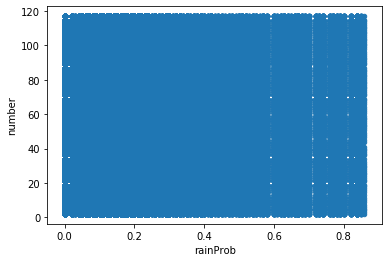

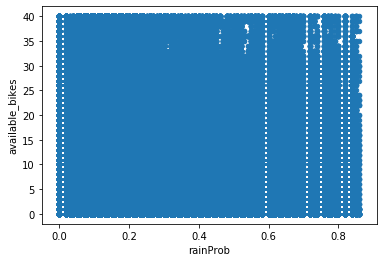

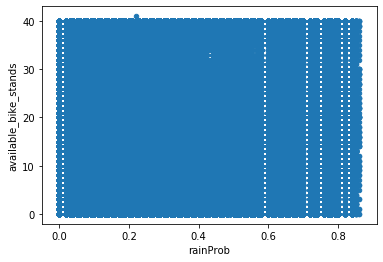

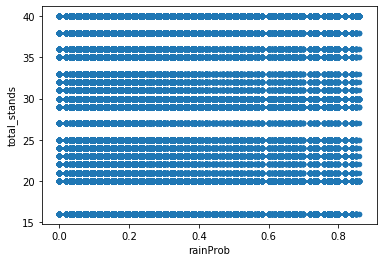

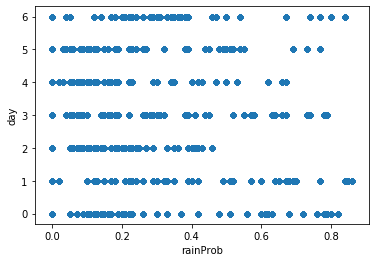

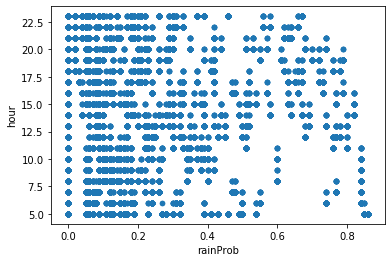

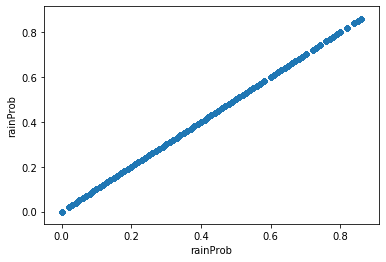

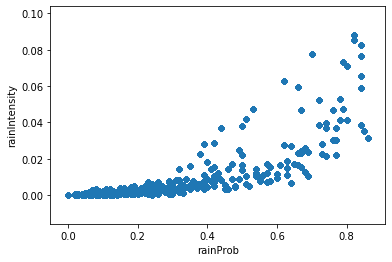

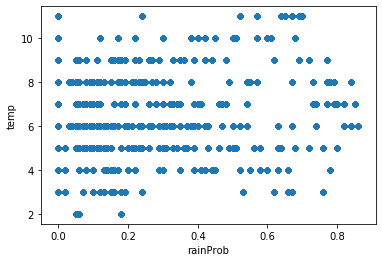

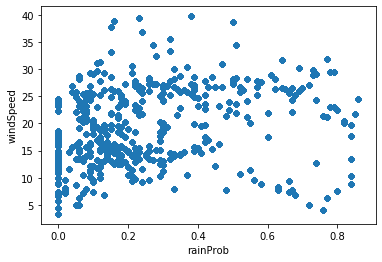

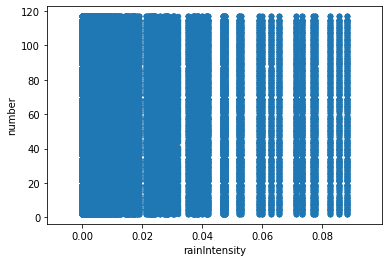

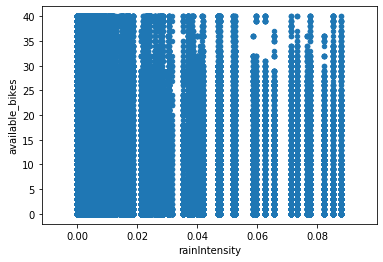

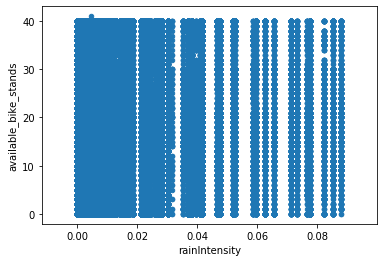

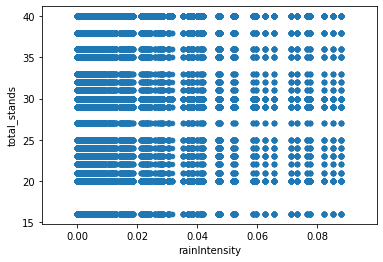

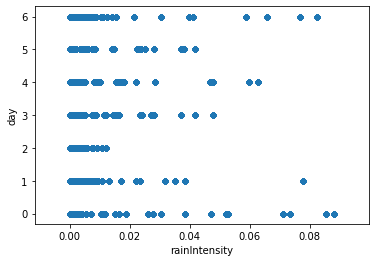

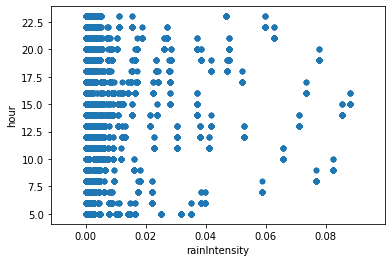

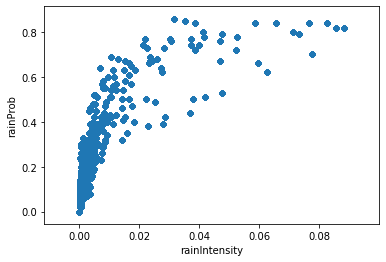

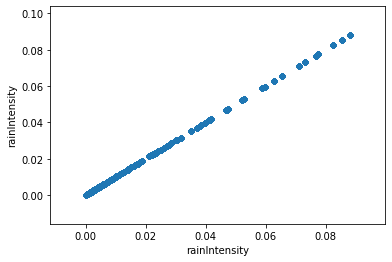

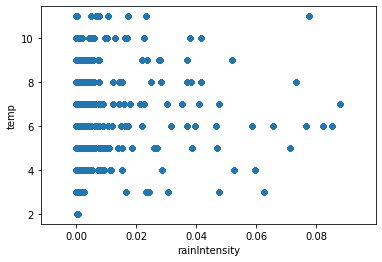

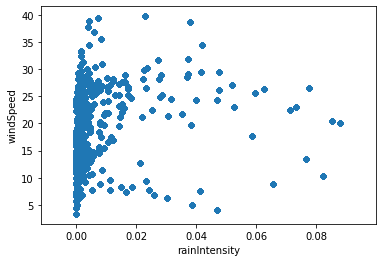

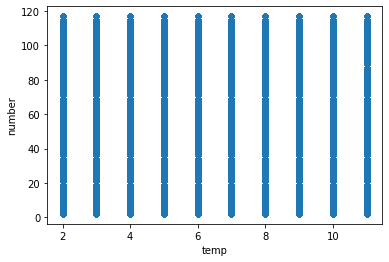

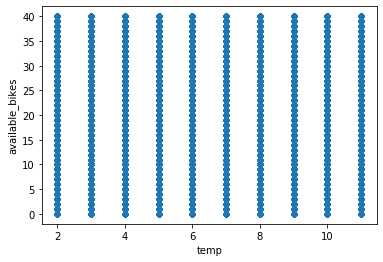

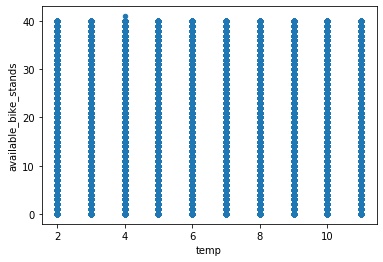

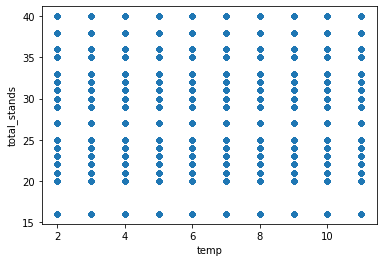

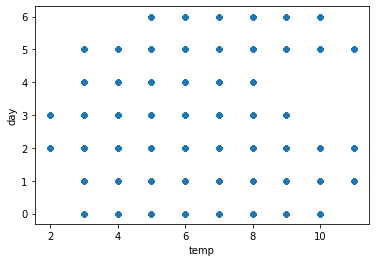

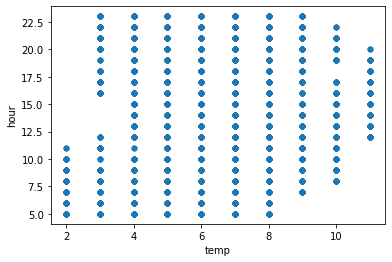

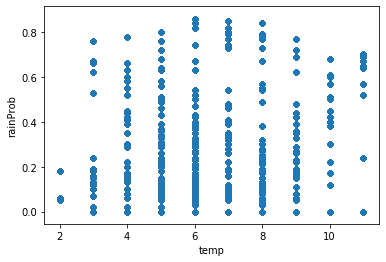

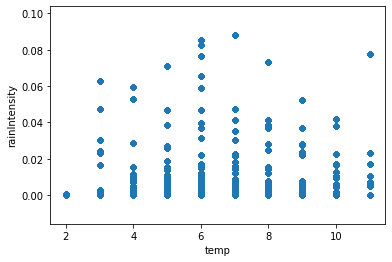

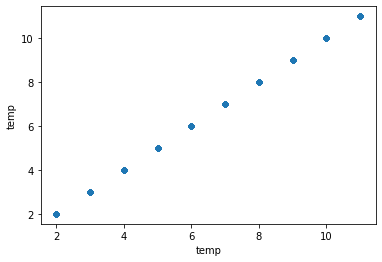

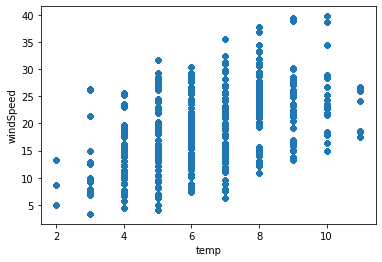

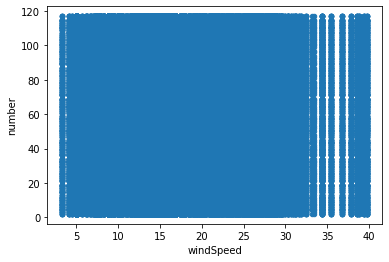

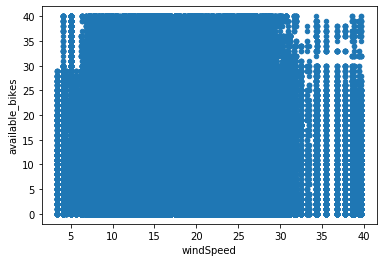

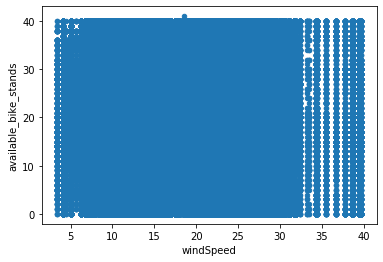

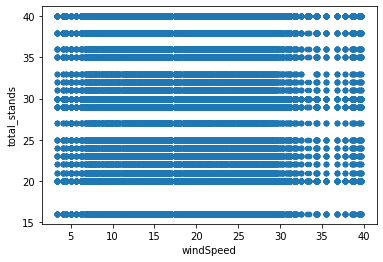

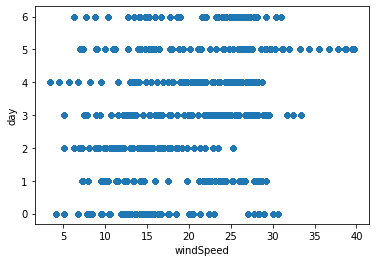

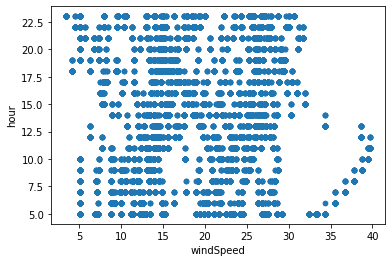

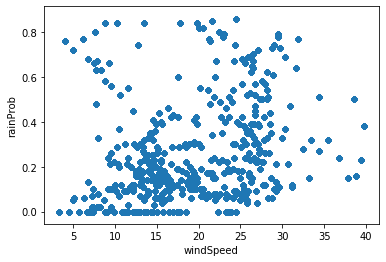

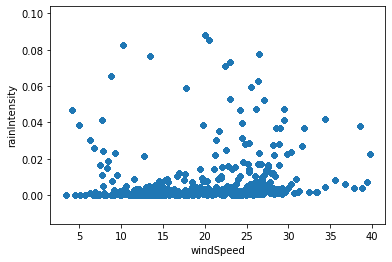

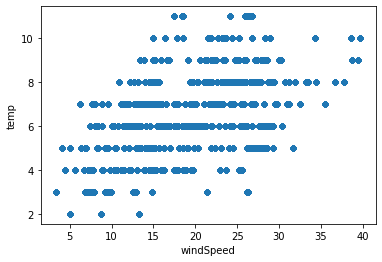

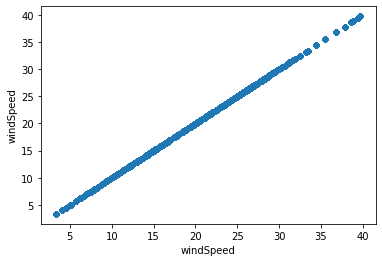

In [83]:
# Warning, this cell has a long running time!
# Plot scatter plots for the continuous columns.
for i in continuous_columns:
     for j in continuous_columns:
         final_df.plot(kind='scatter', x=i, y=j)

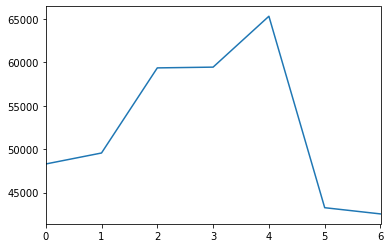

In [84]:
# Plot value counts for days.
final_df.day.value_counts().sort_index().plot()

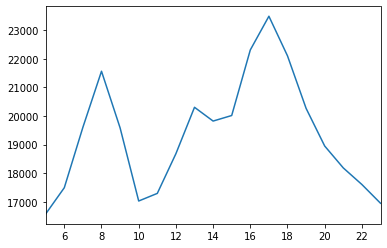

In [85]:
# Plot value counts for hours.
final_df.hour.value_counts().sort_index().plot()

In [86]:
final_df.head()

,number,status,available_bikes,available_bike_stands,last_update,banking,total_stands,day,hour,rainProb,rainIntensity,temp,windSpeed
0,76,OPEN,4,34,2020-02-19 13:01:00,False,38,2,13,0.23,0.0026,6,22.86
1,115,OPEN,2,27,2020-02-19 13:01:00,False,30,2,13,0.23,0.0026,6,22.86
2,91,OPEN,2,28,2020-02-19 13:01:00,False,30,2,13,0.23,0.0026,6,22.86
3,51,OPEN,14,26,2020-02-19 13:01:00,False,40,2,13,0.23,0.0026,6,22.86
4,55,OPEN,11,24,2020-02-19 13:01:00,False,36,2,13,0.23,0.0026,6,22.86


In [87]:
final_df = final_df.drop('status', axis = 1)
final_df = final_df.drop('banking', axis = 1)
final_df = final_df.drop('available_bike_stands', axis = 1)
final_df = final_df.drop('windSpeed', axis = 1)
final_df = final_df.drop('rainIntensity', axis = 1)

In [88]:
# Create dummy variables for the days of the week.
day_dummies = pd.get_dummies(final_df['day'], prefix='day')
final_df = pd.concat([final_df, day_dummies], axis=1)
final_df = final_df.drop('day', axis = 1)

In [89]:
final_df.dtypes

number                      int32
available_bikes             int32
last_update        datetime64[ns]
total_stands                int64
hour                        int64
rainProb                  float64
temp                        int64
day_0                       uint8
day_1                       uint8
day_2                       uint8
day_3                       uint8
day_4                       uint8
day_5                       uint8
day_6                       uint8
dtype: object

In [90]:
# Create dummy variables for the hours.
hour_dummies = pd.get_dummies(final_df['hour'], prefix='hour')
final_df = pd.concat([final_df, hour_dummies], axis=1)
final_df = final_df.drop('hour', axis = 1)

In [91]:
final_df.head().T


,0,1,2,3,4
number,76,115,91,51,55
available_bikes,4,2,2,14,11
last_update,2020-02-19 13:01:00,2020-02-19 13:01:00,2020-02-19 13:01:00,2020-02-19 13:01:00,2020-02-19 13:01:00
total_stands,38,30,30,40,36
rainProb,0.23,0.23,0.23,0.23,0.23
temp,6,6,6,6,6
day_0,0,0,0,0,0
day_1,0,0,0,0,0
day_2,1,1,1,1,1
day_3,0,0,0,0,0


In [92]:
final_df = final_df.drop('last_update', axis = 1)

In [93]:
final_df = final_df.drop('rainProb', axis = 1)

In [94]:
final_df = final_df.drop('temp', axis = 1)

In [95]:
# Labels are the values we want to predict
labels = np.array(final_df['available_bikes'])
# Remove the labels from the features
features= final_df.drop('available_bikes', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [96]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

In [97]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (275850, 28)
Training Labels Shape: (275850,)
Testing Features Shape: (91950, 28)
Testing Labels Shape: (91950,)


In [98]:
# Random Forest Regression Model
rf = RandomForestRegressor()
# Train the model on training data
rf.fit(train_features, train_labels);

In [99]:
# Use the random forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 4.28


In [100]:
test_set_rmse = (np.sqrt(mean_squared_error(test_labels, predictions)))

test_set_r2 = r2_score(test_labels, predictions)

In [101]:
# Print the RMSE and R2.
# We got an R2 of 0.70287 which is quite good considering the quality and lack of data.
print(test_set_rmse)
print(test_set_r2)

5.7762397521005
0.7028792458663189


In [106]:
# Save the model in a pickle file for use in the app.
import pickle
pickle.dump(rf, open('model.pkl','wb'))


In [108]:
# Carry out a predicition with the model.
model = pickle.load(open('static/models/model.pkl','rb'))
print(model.predict([[51,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]]))

[17.80208113]


In [103]:
# There were issues with the model serialised with pickle so we decided to try joblib
# This worked a lot better for us and no errors occured in the deployed app.

joblib_file = "joblib_model.pkl"
joblib.dump(rf, joblib_file)

['joblib_model.pkl']

In [109]:
joblib_model = joblib.load(joblib_file)
print(joblib_model.predict([[51,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]]))

[17.15784923]


In [107]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: number               Importance: 0.3
Variable: total_stands         Importance: 0.12
Variable: day_6                Importance: 0.06
Variable: day_5                Importance: 0.05
Variable: hour_8               Importance: 0.03
Variable: day_0                Importance: 0.02
Variable: day_4                Importance: 0.02
Variable: hour_5               Importance: 0.02
Variable: hour_6               Importance: 0.02
Variable: hour_7               Importance: 0.02
Variable: hour_9               Importance: 0.02
Variable: hour_10              Importance: 0.02
Variable: hour_11              Importance: 0.02
Variable: hour_12              Importance: 0.02
Variable: hour_13              Importance: 0.02
Variable: hour_14              Importance: 0.02
Variable: hour_15              Importance: 0.02
Variable: hour_16              Importance: 0.02
Variable: hour_17              Importance: 0.02
Variable: hour_18              Importance: 0.02
Variable: hour_19              Importance

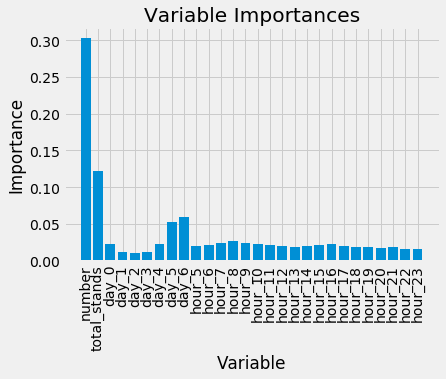

In [108]:

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


## Create a vector which can be used to predict bike availability with given inputs.


In [109]:
def initDF():
    # list for relevant hours
    hours = [0] * 19
    # list for days
    days = [0] * 7
    # station number
    number = [0] * 1
    # total number of stands at station
    stands = [0] * 1
    # Combine to form vector
    data = [number + stands + days + hours]
    
    df = pd.DataFrame(data, columns=['number', 'total_stands', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
                                  'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
                                  'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'])
    
    return df

In [110]:
# Assign vector data frame to test variable.
test = initDF()

In [111]:
# All values should be 0.
test.head().T

,0
number,0
total_stands,0
day_0,0
day_1,0
day_2,0
day_3,0
day_4,0
day_5,0
day_6,0
hour_5,0


In [115]:
# dict with values to be put in vector data frame.
inputs = {'number': 51, 'total_stands': 40, 'day': '2', 'hour': '13'}

In [116]:
# function which passes values from dict to relevant position in the data frame.
def setEntryValues(df, dict):
    df['number'][0] = dict['number']
    df['total_stands'][0] = dict['total_stands']
    df['day_' + dict['day']][0] = 1
    df['hour_' + dict['hour']][0] = 1
    

In [ ]:
setEntryValues(test, inputs)

In [118]:
test.head().T

,0
number,51
total_stands,40
day_0,0
day_1,0
day_2,1
day_3,0
day_4,0
day_5,0
day_6,0
hour_5,0


In [119]:
# Carry out a prediction using the test variable.
model = pickle.load(open('model.pkl','rb'))
print(model.predict(test))

[17.80208113]


## Linear Regression Attempt
Decided to test a linear regression model as well in order to see how it compared to Random Forest. <br/>
The model had very poor levels of accuracy. <br/>
Its RMSE was 10.295 and R2 was 0.064 <br/>
The Random Forest model, therefore, had a much higher level of accuracy.

In [102]:
lin_reg_mod = LinearRegression()

In [103]:
lin_reg_mod.fit(train_features, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
pred = lin_reg_mod.predict(test_features)

In [105]:
test_set_rmse_1 = (np.sqrt(mean_squared_error(test_labels, pred)))

test_set_r2_1 = r2_score(test_labels, pred)

In [106]:
print(test_set_rmse_1)
print(test_set_r2_1)

10.295692144524518
0.06404409585946147
